In [1]:
from azure.cognitiveservices.anomalydetector import AnomalyDetectorClient
from azure.cognitiveservices.anomalydetector.models import Request, Point, Granularity, \
    APIErrorException
from msrest.authentication import CognitiveServicesCredentials
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# URLs for anomaly detection with the Anomaly Detector API
batch_detection_url = "/anomalydetector/v1.0/timeseries/entire/detect"

# This sample assumes you have created an environment variable for your key and endpoint
endpoint = os.environ["ANOMALY_DETECTOR_ENDPOINT"]
subscription_key = os.environ["ANOMALY_DETECTOR_KEY"]

In [3]:
#Authenticate the client
client=AnomalyDetectorClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [4]:
data=pd.read_csv('Output/X_train_formateado.csv', encoding='utf-8')
data

,asset_id,group_id,week,weekday,t1,t2,t3,t4,total_t,week_day,date,day
0,1,2,1,1,NaN,NaN,19.0,0.0,2,1_1,2018-01-01,1
1,1,2,1,2,NaN,NaN,8.0,0.0,2,1_2,2018-01-02,2
2,1,2,1,3,NaN,NaN,9.0,0.0,2,1_3,2018-01-03,3
3,1,2,1,4,NaN,NaN,6.0,0.0,2,1_4,2018-01-04,4
4,1,2,1,5,NaN,NaN,6.0,2.0,2,1_5,2018-01-05,5
...,...,...,...,...,...,...,...,...,...,...,...,...
60419,83,3,104,3,1.0,0.0,48.0,8.0,4,104_3,2019-12-25,724
60420,83,3,104,4,0.0,0.0,37.0,1.0,4,104_4,2019-12-26,725
60421,83,3,104,5,1.0,0.0,48.0,9.0,4,104_5,2019-12-27,726
60422,83,3,104,6,2.0,0.0,53.0,11.0,4,104_6,2019-12-28,727


In [5]:
data['borrar']='T00:00:00Z'
data['date']=data['date']+data['borrar']
data['date']=pd.to_datetime(data['date'])
data=data.drop('borrar', axis=1)
data

,asset_id,group_id,week,weekday,t1,t2,t3,t4,total_t,week_day,date,day
0,1,2,1,1,NaN,NaN,19.0,0.0,2,1_1,2018-01-01 00:00:00+00:00,1
1,1,2,1,2,NaN,NaN,8.0,0.0,2,1_2,2018-01-02 00:00:00+00:00,2
2,1,2,1,3,NaN,NaN,9.0,0.0,2,1_3,2018-01-03 00:00:00+00:00,3
3,1,2,1,4,NaN,NaN,6.0,0.0,2,1_4,2018-01-04 00:00:00+00:00,4
4,1,2,1,5,NaN,NaN,6.0,2.0,2,1_5,2018-01-05 00:00:00+00:00,5
...,...,...,...,...,...,...,...,...,...,...,...,...
60419,83,3,104,3,1.0,0.0,48.0,8.0,4,104_3,2019-12-25 00:00:00+00:00,724
60420,83,3,104,4,0.0,0.0,37.0,1.0,4,104_4,2019-12-26 00:00:00+00:00,725
60421,83,3,104,5,1.0,0.0,48.0,9.0,4,104_5,2019-12-27 00:00:00+00:00,726
60422,83,3,104,6,2.0,0.0,53.0,11.0,4,104_6,2019-12-28 00:00:00+00:00,727


In [6]:
data=data.set_index('asset_id')
porAsset=data.groupby(data.index)

### Cargar los datos de una serie de tiempo (t1, t2, t3 o t4) para un ASSET

In [7]:
ASSET=30
t='t3'
asset  = porAsset.get_group(ASSET).reset_index()

series=[]
for index, row in asset.iterrows():
    series.append(Point(timestamp=row['date'].isoformat(),value=row[t]))

request= Request(series=series, granularity=Granularity.daily, period=7, sensitivity=20)

### Detectar anomalías en la serie

In [8]:
try:
    response = client.entire_detect(request)
except Exception as e:
    if isinstance(e, APIErrorException):
        print('Error code: {}'.format(e.error.code),
            'Error message: {}'.format(e.error.message))
    else:
        print(e)


respuesta=response.as_dict()

#Crear df anomlias con resultados en el diccionario respuesta
for key, value in respuesta.items():
    anomalias=pd.DataFrame(respuesta)
    
    
print('número de anomalias positivas: ',anomalias[anomalias['is_positive_anomaly']==True].shape[0])
print('número de anomalias negativas: ',anomalias[anomalias['is_negative_anomaly']==True].shape[0])

#Agregar columna a asset
asset['outlier_'+t]=anomalias['is_positive_anomaly'].astype(int)
asset['is_anomaly']=anomalias['is_anomaly']
asset['is_positive_anomaly']=anomalias['is_positive_anomaly']
asset['is_negative_anomaly']=anomalias['is_negative_anomaly']
asset

número de anomalias positivas:  6
número de anomalias negativas:  0


,asset_id,group_id,week,weekday,t1,t2,t3,t4,total_t,week_day,date,day,outlier_t3,is_anomaly,is_positive_anomaly,is_negative_anomaly
0,30,3,1,1,NaN,NaN,26.0,4.0,2,1_1,2018-01-01 00:00:00+00:00,1,0,False,False,False
1,30,3,1,2,NaN,NaN,62.0,6.0,2,1_2,2018-01-02 00:00:00+00:00,2,0,False,False,False
2,30,3,1,3,NaN,NaN,73.0,2.0,2,1_3,2018-01-03 00:00:00+00:00,3,0,False,False,False
3,30,3,1,4,NaN,NaN,73.0,4.0,2,1_4,2018-01-04 00:00:00+00:00,4,0,False,False,False
4,30,3,1,5,NaN,NaN,57.0,3.0,2,1_5,2018-01-05 00:00:00+00:00,5,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,30,3,104,3,NaN,NaN,97.0,8.0,2,104_3,2019-12-25 00:00:00+00:00,724,0,False,False,False
724,30,3,104,4,NaN,NaN,102.0,7.0,2,104_4,2019-12-26 00:00:00+00:00,725,0,False,False,False
725,30,3,104,5,NaN,NaN,84.0,8.0,2,104_5,2019-12-27 00:00:00+00:00,726,0,False,False,False
726,30,3,104,6,NaN,NaN,58.0,8.0,2,104_6,2019-12-28 00:00:00+00:00,727,0,False,False,False


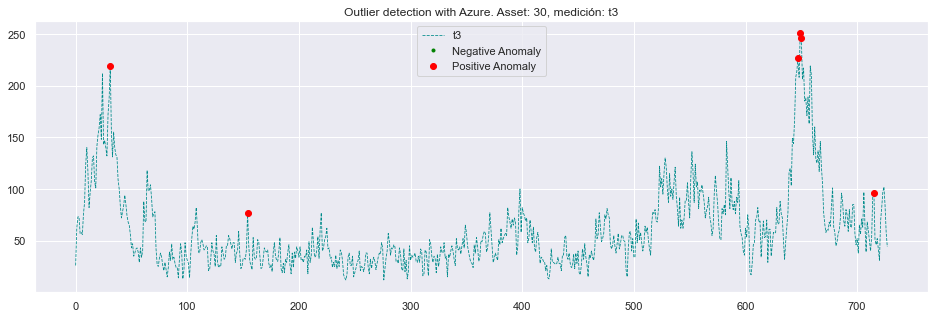

In [10]:
sns.set(rc={'figure.figsize':(16,5)}, palette="muted")
normal=asset[asset['is_anomaly']==False][t]
negative_anomaly=asset[asset['is_negative_anomaly']==True][t]
positive_anomaly=asset[asset['is_positive_anomaly']==True][t]
titulo= "Outlier detection with Azure. Asset: "  + str(ASSET) + ", medición: " + t

#Visualización de anomalias 

plt.plot(asset[t],ls='--',color='darkcyan', linewidth=.8)
plt.plot(negative_anomaly.index, negative_anomaly, '.', color='green')
plt.plot(positive_anomaly.index, positive_anomaly, 'o', color='red')

plt.legend([ t, 'Negative Anomaly', 'Positive Anomaly' ])
plt.title(titulo)
plt.show()